# An Empirical Study of Classification Algorithms for Health Data


In [641]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import PCA

## 1. Data Loading and Preprocessing
- Load all datasets  and perform any necessary preprocessing (e.g., handling missing values, encoding categorical variables, scaling features).
- Split each dataset into training and testing sets, or set up for k-fold cross-validation.

In [5]:
# directories
dir_data = os.path.join('data')

In [563]:
def prepare_data(df, target_col, test_sizes, validation_size=0.2, random_state=42):
    """
    Splits a dataset into multiple train/test splits and scales features.
    
    Parameters:
        df (DataFrame): The dataset.
        target_col (str): The name of the target column.
        test_sizes (list): List of test sizes (e.g., [0.2, 0.5, 0.8]).
        random_state (int): Random state for reproducibility.
    
    Returns:
        splits (dict): Dictionary of splits with scaled features.
    """
    scaler = StandardScaler()
    splits = {}
    
    # Split features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Handle missing values
    X.fillna(X.mean(), inplace=True)

    list_splits = ['80/20', '50/50', '20/80']
    # Generate splits
    for test_size, split in zip(test_sizes, list_splits):
        # Split into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Further split the train set into train/validation
        #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)
        
        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        #X_valid_scaled = scaler.transform(X_valid)
        X_test_scaled = scaler.transform(X_test)

        splits[split] = {
            'X_train': X_train_scaled,
            #'X_valid': X_valid_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            #'y_valid': y_valid,
            'y_test': y_test,
        }
        
        print(f"({split} Split) Train size: {X_train_scaled.shape}, Validation size: 0, Test size: {X_test_scaled.shape}")
    
    return splits

### Haberman's Survival - UCI ML Repo
http://archive.ics.uci.edu/dataset/43/haberman+s+survival

#### Loading Data

In [565]:
# Load Haberman’s Survival dataset (CSV format)
haberman_path = os.path.join(dir_data, 'haberman', 'haberman.data')
haberman_columns = ['age', 'year', 'nodes', 'survival_status']  # Column names
haberman_df = pd.read_csv(haberman_path, names=haberman_columns)

# Check the first few rows
haberman_df.head()

,age,year,nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


#### Preprocessing Data

In [568]:
# Encode the target variable 'survival_status' (1 = survived, 2 = not survived)
haberman_df['survival_status'] = haberman_df['survival_status'].map({1: 0, 2: 1})
# Preprocessing and splitting Haberman dataset
splits_haberman = prepare_data(haberman_df, target_col='survival_status', test_sizes=[0.2, 0.5, 0.8])

(80/20 Split) Train size: (244, 3), Validation size: 0, Test size: (62, 3)
(50/50 Split) Train size: (153, 3), Validation size: 0, Test size: (153, 3)
(20/80 Split) Train size: (61, 3), Validation size: 0, Test size: (245, 3)


### Breast Cancer Wisconsin (Diagnostic) - UCI ML Repo
http://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

#### Loading Data

In [570]:
# Load Breast Cancer Wisconsin (Diagnostic) dataset (CSV format)
wdbc_path = os.path.join(dir_data, 'wdbc', 'wdbc.data')
wdbc_columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]  # Column names
wdbc_df = pd.read_csv(wdbc_path, names=wdbc_columns)

# Check the first few rows
wdbc_df.head()

,id,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Preprocessing Data

In [573]:
# Convert the target variable 'diagnosis' to numeric (M=1, B=0)
wdbc_df['diagnosis'] = wdbc_df['diagnosis'].map({'M': 1, 'B': 0})

# Preprocessing and splitting WDBC dataset
splits_wdbc = prepare_data(wdbc_df, target_col='diagnosis', test_sizes=[0.2, 0.5, 0.8])

(80/20 Split) Train size: (455, 31), Validation size: 0, Test size: (114, 31)
(50/50 Split) Train size: (284, 31), Validation size: 0, Test size: (285, 31)
(20/80 Split) Train size: (113, 31), Validation size: 0, Test size: (456, 31)


### Early Stage Diabetes Risk Prediction - UCI ML Repo
http://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset

#### Loading Data

In [576]:
# Load Early Stage Diabetes Risk Prediction dataset (CSV format)
diabetes_path = os.path.join(dir_data, 'diabetes', 'diabetes_data_upload.csv')
diabetes_df = pd.read_csv(diabetes_path)

# Check the first few rows to understand its structure
diabetes_df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


#### Preprocessing Data

In [579]:
# Convert the target variable 'class' to numeric (positive=1, negative=0)
diabetes_df['class'] = diabetes_df['class'].map({'Positive': 1, 'Negative': 0})

# Preprocessing and splitting Diabetes dataset
diabetes_df['Gender'] = diabetes_df['Gender'].map({'Male': 1, 'Female': 0})
for col in diabetes_df.columns:
    if diabetes_df[col].dtype == 'object' and col != 'Age':  # Encode Categorical columns
        diabetes_df[col] = diabetes_df[col].map({'Yes': 1, 'No': 0})

splits_diabetes = prepare_data(diabetes_df, target_col='class', test_sizes=[0.2, 0.5, 0.8])

(80/20 Split) Train size: (416, 16), Validation size: 0, Test size: (104, 16)
(50/50 Split) Train size: (260, 16), Validation size: 0, Test size: (260, 16)
(20/80 Split) Train size: (104, 16), Validation size: 0, Test size: (416, 16)


## 2. Model Definitions
- Define each classifier (SVM, Logistic Regression, Random Forest, etc.) as functions or classes.
- Set up hyperparameter grids for each model to use in cross-validation.

In [691]:
def define_svm():
    """
    Define the SVM model and its hyperparameter grid.
    """
    model = SVC(probability=True)
    param_grid = {
        "kernel": ["linear", "poly", "rbf"],  # Different kernel types
        "C": [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 10000],
        "degree": [2, 3],  # Only applicable to the polynomial kernel
        "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2],  # Applicable to 'rbf' and 'poly'
    }
    return model, param_grid

def define_logistic_regression():
    """
    Define the Logistic Regression model and its hyperparameter grid.
    """
    model = LogisticRegression()
    param_grid = {
        "C": [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
    }
    return model, param_grid

def define_random_forest():
    """
    Define the Random Forest model and its hyperparameter grid.
    """
    model = RandomForestClassifier()
    param_grid = {
        "n_estimators": [100, 200, 500],
        "max_features": [1, 2, 4, 6, 8, 12, 16, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
    }
    return model, param_grid

def define_neural_network():
    """
    Define the Neural Network model and its hyperparameter grid.
    """
    model = MLPClassifier(max_iter=500, random_state=42)
    param_grid = {
        "hidden_layer_sizes": [(i,) for i in [1, 2, 4, 8, 32, 128]],
        "momentum": [0, 0.2, 0.5, 0.9],
        "activation": ['relu', 'tanh'],
        "solver": ['sgd', 'adam'],
        "learning_rate": ['constant', 'invscaling', 'adaptive'],
        "early_stopping": [True],
        "n_iter_no_change": [10],
    }
    return model, param_grid

In [693]:
def get_models():
    """
    Returns all models and their hyperparameter grids in a dictionary.
    """
    return {
        "SVM": define_svm(),
        "Logistic Regression": define_logistic_regression(),
        "Random Forest": define_random_forest(),
        "Neural Network (ANN)": define_neural_network(),
    }

## 3. Hyper-parameter Tuning and Training
- Use RandomizedSearchCV for hyperparameter optimization.
- Store each classifier's best model.

### Hyper-parameter Cross Validation

In [587]:
# Function to perform hyperparameter tuning using RandomizedSearchCV
def tune_model(model, param_dist, X_train, y_train, n_iter=10, cv=3, scoring='accuracy'):
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Fit the model to the training data
    random_search.fit(X_train, y_train)

    # Return the best model
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_


In [589]:
results = []

# Define datasets
datasets = {
    "Haberman": splits_haberman,
    "WDBC": splits_wdbc,
    "Diabetes": splits_diabetes,
}

# Define partitions
splits_to_process = ['80/20', '50/50', '20/80']

models = get_models()

for model_name, (model, param_dist) in models.items():
    for dataset_name, splits in datasets.items():
        for split_name in splits_to_process:
            X_train = splits[split_name]['X_train']
            y_train = splits[split_name]['y_train']
            
            # Perform RandomizedSearchCV for each model and save the results
            best_model, best_params, best_score = tune_model(model, param_dist, X_train, y_train)
        
            # Save results into a list
            results.append({
                'Model': model_name,
                'Dataset': dataset_name,
                'Split': split_name,
                'Best Parameters': best_params,
                'Best Score': best_score
            })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

In [591]:
results_df

,Model,Dataset,Split,Best Parameters,Best Score
0,SVM,Haberman,80/20,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.758105
1,SVM,Haberman,50/50,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.712418
2,SVM,Haberman,20/80,"{'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, '...",0.738095
3,SVM,WDBC,80/20,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.958188
4,SVM,WDBC,50/50,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.971781
5,SVM,WDBC,20/80,"{'kernel': 'linear', 'gamma': 0.05, 'degree': ...",0.911569
6,SVM,Diabetes,80/20,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.954332
7,SVM,Diabetes,50/50,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.934732
8,SVM,Diabetes,20/80,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ...",0.942577
9,Logistic Regression,Haberman,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}",0.770451


In [595]:
results_df.to_csv(os.path.join(dir_data, 'hyperparam_results.csv'), index=True)

In [609]:
results_df['Best Parameters'] = results_df['Best Parameters'].apply(str)

# Define aggregation function
def aggregate_best_params(params_series):
    most_frequent = params_series.mode()
    if len(most_frequent) == 1:
        return most_frequent.iloc[0]  # Return the most frequent parameter set
    else:
        return 'Multiple Values'  # If there are multiple modes, return this message


# Average the best scores across the partitions for each model and dataset
avg_results = results_df.groupby(['Model', 'Dataset']).agg(
    avg_best_score=('Best Score', 'mean'),
    avg_best_params=('Best Parameters', aggregate_best_params)
).reset_index()

# Convert the string 'Best Parameters' back to dictionary (if possible)
avg_results['avg_best_params'] = avg_results['avg_best_params'].apply(
    lambda x: eval(x) if isinstance(x, str) and x != 'Multiple Values' else x
)

avg_results

,Model,Dataset,avg_best_score,avg_best_params
0,Logistic Regression,Diabetes,0.912411,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}"
1,Logistic Regression,Haberman,0.742500,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}"
2,Logistic Regression,WDBC,0.957356,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}"
3,Neural Network (ANN),Diabetes,0.614518,"{'solver': 'sgd', 'n_iter_no_change': 10, 'mom..."
4,Neural Network (ANN),Haberman,0.751198,"{'solver': 'sgd', 'n_iter_no_change': 10, 'mom..."
5,Neural Network (ANN),WDBC,0.666762,"{'solver': 'adam', 'n_iter_no_change': 10, 'mo..."
6,Random Forest,Diabetes,0.959340,"{'n_estimators': 100, 'min_samples_split': 2, ..."
7,Random Forest,Haberman,0.709423,"{'n_estimators': 200, 'min_samples_split': 5, ..."
8,Random Forest,WDBC,0.950997,Multiple Values
9,SVM,Diabetes,0.943880,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ..."


In [615]:
results_df['Best Parameters'] = results_df['Best Parameters'].apply(str)

# Define aggregation function
def aggregate_best_params(params_series):
    most_frequent = params_series.mode()
    if len(most_frequent) == 1:
        return most_frequent.iloc[0]  # Return the most frequent parameter set
    else:
        return 'Multiple Values'  # If there are multiple modes, return this message

# Optimal hyperparameters per model
# Average the best scores across the partitions for each model and dataset
opt_hyperparams = results_df.groupby(['Model']).agg(
    avg_best_score=('Best Score', 'mean'),
    avg_best_params=('Best Parameters', aggregate_best_params)
).reset_index()

# Convert the string 'Best Parameters' back to dictionary (if possible)
opt_hyperparams['avg_best_params'] = opt_hyperparams['avg_best_params'].apply(
    lambda x: eval(x) if isinstance(x, str) and x != 'Multiple Values' else x
)

opt_hyperparams

,Model,avg_best_score,avg_best_params
0,Logistic Regression,0.870756,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}"
1,Neural Network (ANN),0.677493,"{'solver': 'sgd', 'n_iter_no_change': 10, 'mom..."
2,Random Forest,0.873253,"{'n_estimators': 100, 'min_samples_split': 2, ..."
3,SVM,0.875755,"{'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, ..."


In [623]:
# Extract hyperparameter grid from avg_best_params
param_grids = {}
for idx, row in avg_results.iterrows():
    model_name = row['Model']
    best_params = row['avg_best_params']
    
    if isinstance(best_params, dict):
        param_grids[model_name] = best_params  # Add the hyperparameters for each model

param_grids

{'Logistic Regression': {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1},
 'Neural Network (ANN)': {'solver': 'sgd',
  'n_iter_no_change': 10,
  'momentum': 0,
  'learning_rate': 'adaptive',
  'hidden_layer_sizes': (32,),
  'early_stopping': True,
  'activation': 'tanh'},
 'Random Forest': {'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 1},
 'SVM': {'kernel': 'rbf', 'gamma': 0.05, 'degree': 2, 'C': 10}}

#### Hyper-parameter Heatmaps

In [439]:
# Function to draw heatmaps for hyperparameter error rates
def draw_heatmap(errors, param_x, param_y, x_label, y_label, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(errors, interpolation='nearest', cmap='viridis', aspect='auto')
    plt.colorbar(label='Error Rate')
    plt.xticks(np.arange(len(param_x)), labels=param_x, rotation=45)
    plt.yticks(np.arange(len(param_y)), labels=param_y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Function to generate heatmaps for selected parameters
def generate_heatmaps_for_model(model_name, model, param_grid, param_x_name, param_y_name, X_train, y_train, cv=3, scoring='accuracy'):
    param_x = param_grid[param_x_name]
    param_y = param_grid[param_y_name]

    # Arrays to store error rates
    train_errors = np.zeros((len(param_x), len(param_y)))
    valid_errors = np.zeros((len(param_x), len(param_y)))

    # Evaluate model for every combination of parameters
    for i, x_val in enumerate(param_x):
        for j, y_val in enumerate(param_y):
            # Update model with parameters
            kwargs = {param_x_name: x_val, param_y_name: y_val}
            model.set_params(**kwargs)

            # Fit model and calculate training error
            model.fit(X_train, y_train)
            train_errors[i, j] = 1 - model.score(X_train, y_train)  # Training error

            # Cross-validation for validation error
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
            valid_errors[i, j] = 1 - np.mean(cv_scores)  # Validation error

    # Draw heatmaps
    draw_heatmap(train_errors, param_y, param_x, param_y_name, param_x_name, f"{model_name} Training Error Heatmap")
    draw_heatmap(valid_errors, param_y, param_x, param_y_name, param_x_name, f"{model_name} Validation Error Heatmap")


Generating heatmaps for SVM on Haberman Split 1


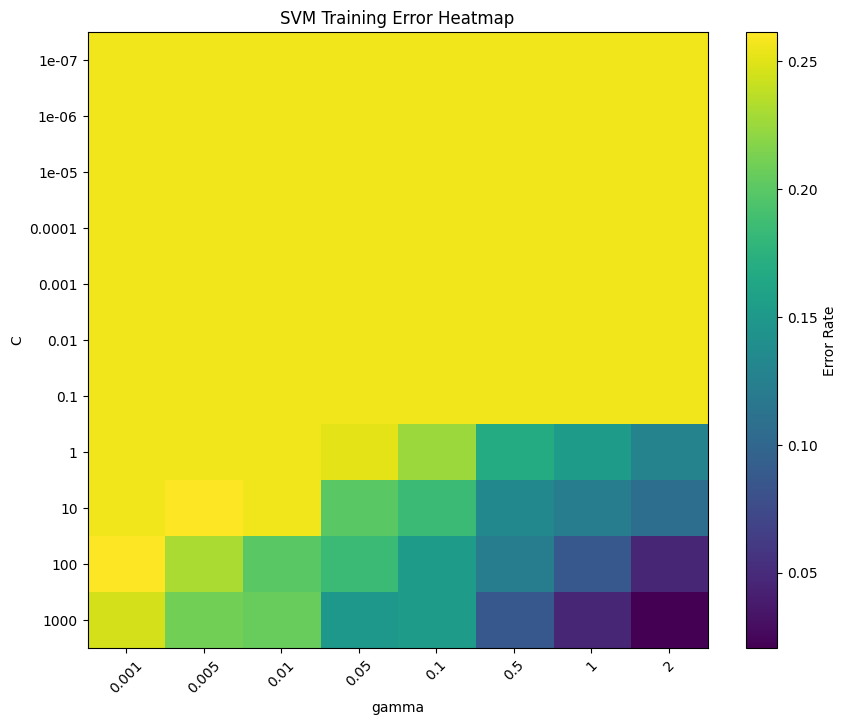

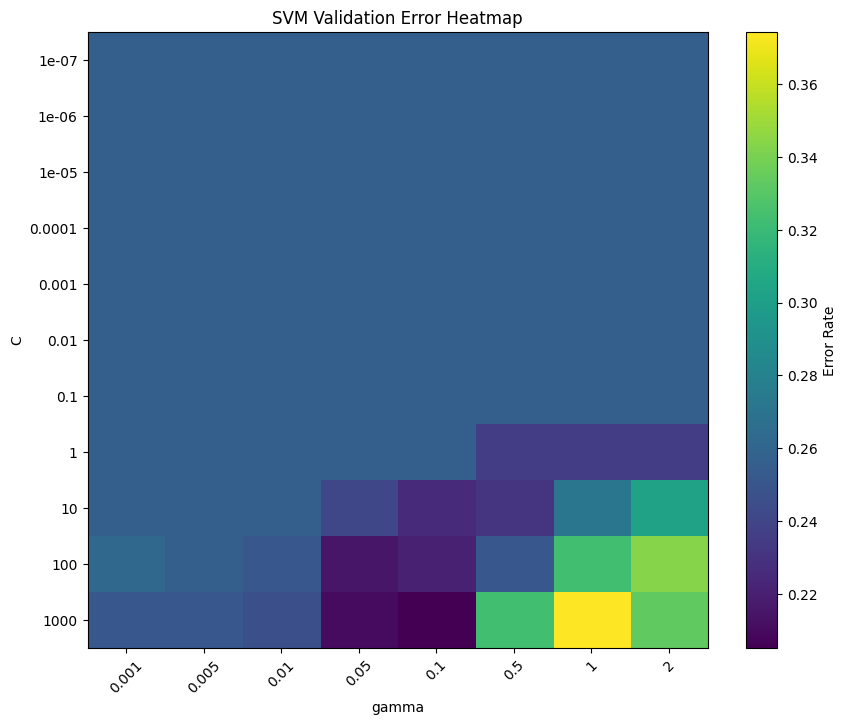

Generating heatmaps for SVM on Haberman Split 2


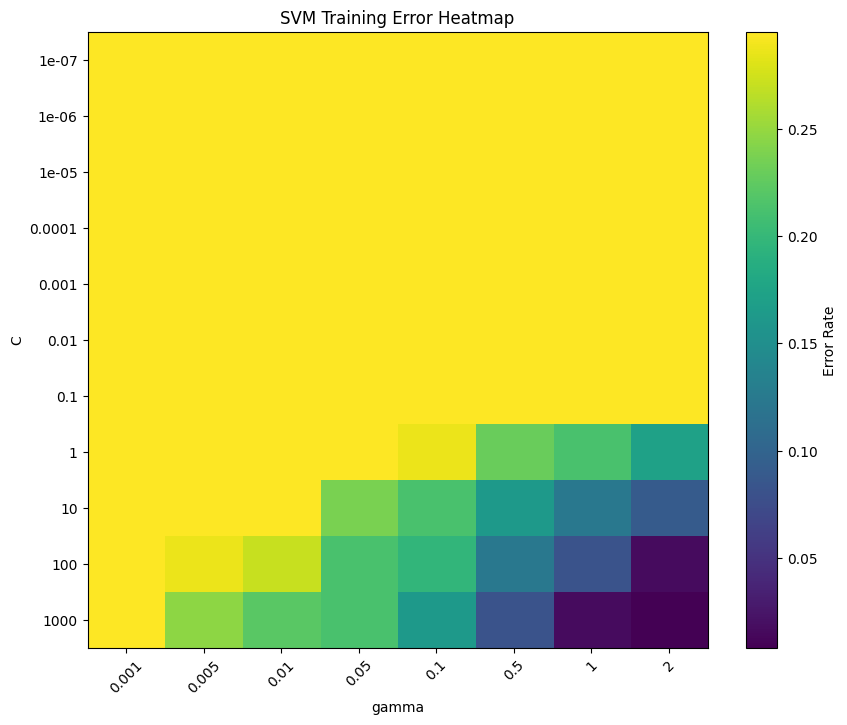

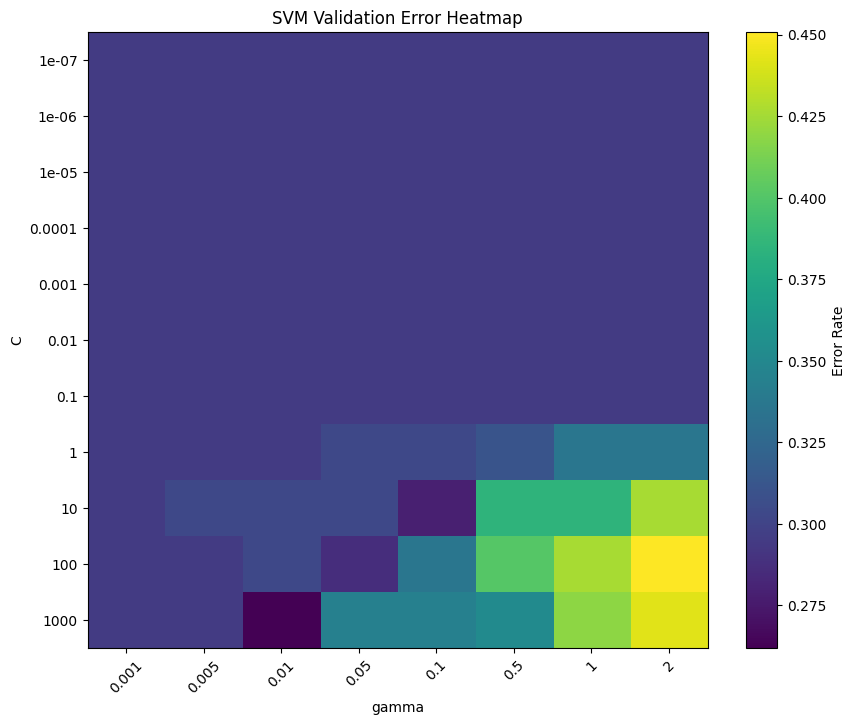

Generating heatmaps for SVM on Haberman Split 3


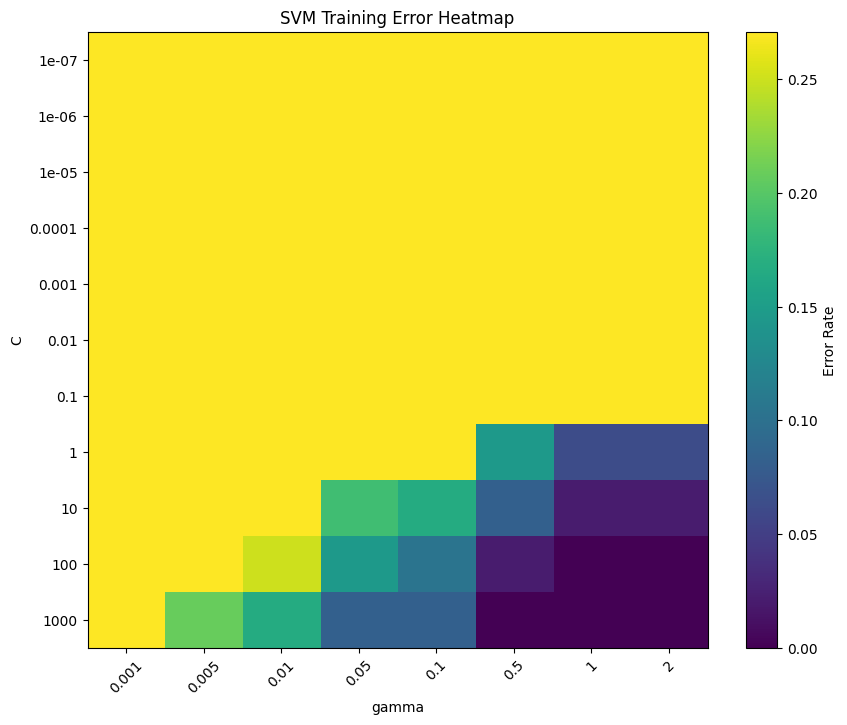

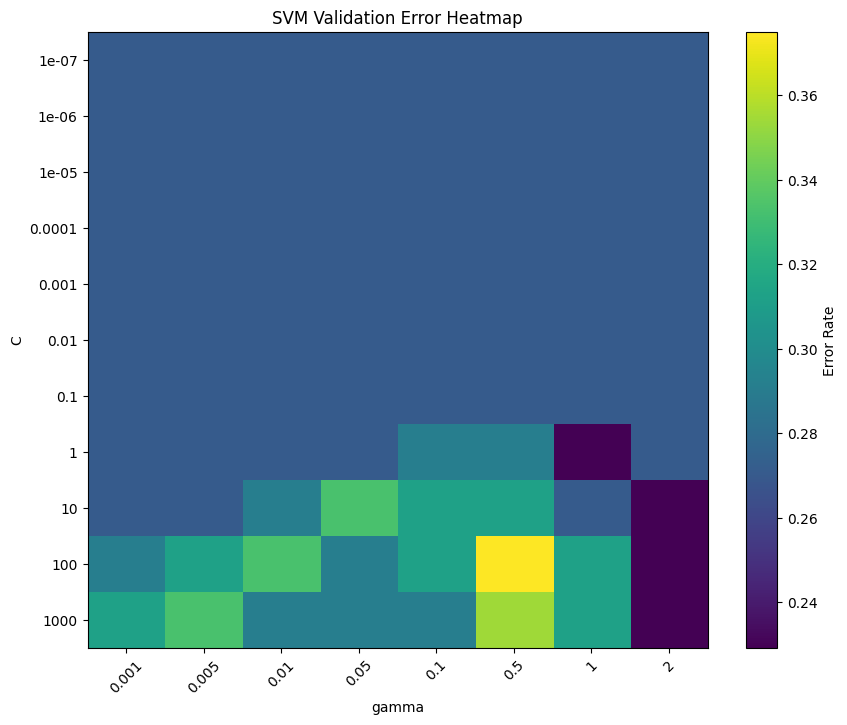

Generating heatmaps for Logistic Regression on Haberman Split 1


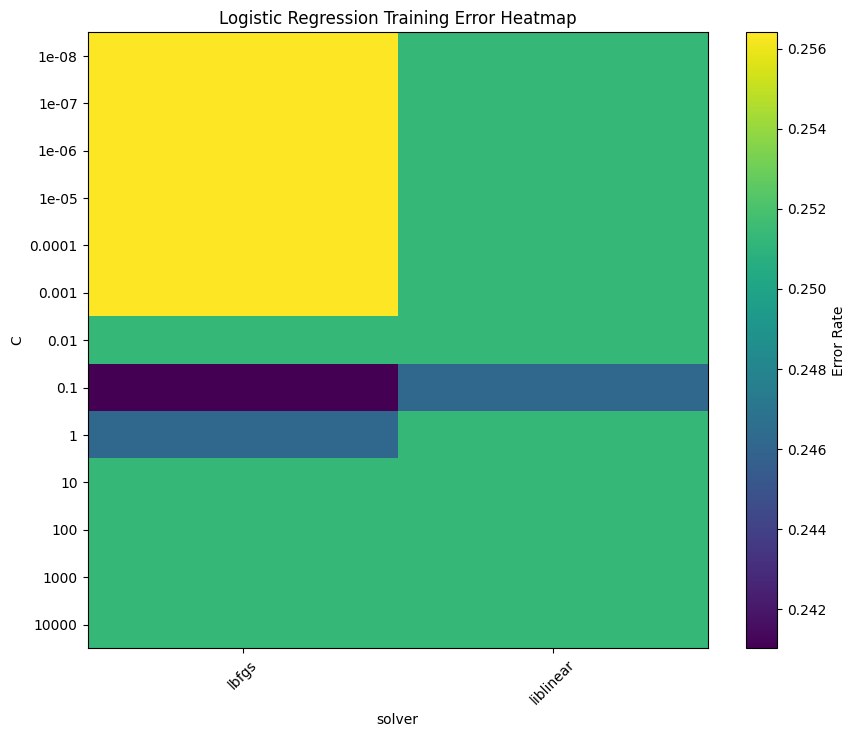

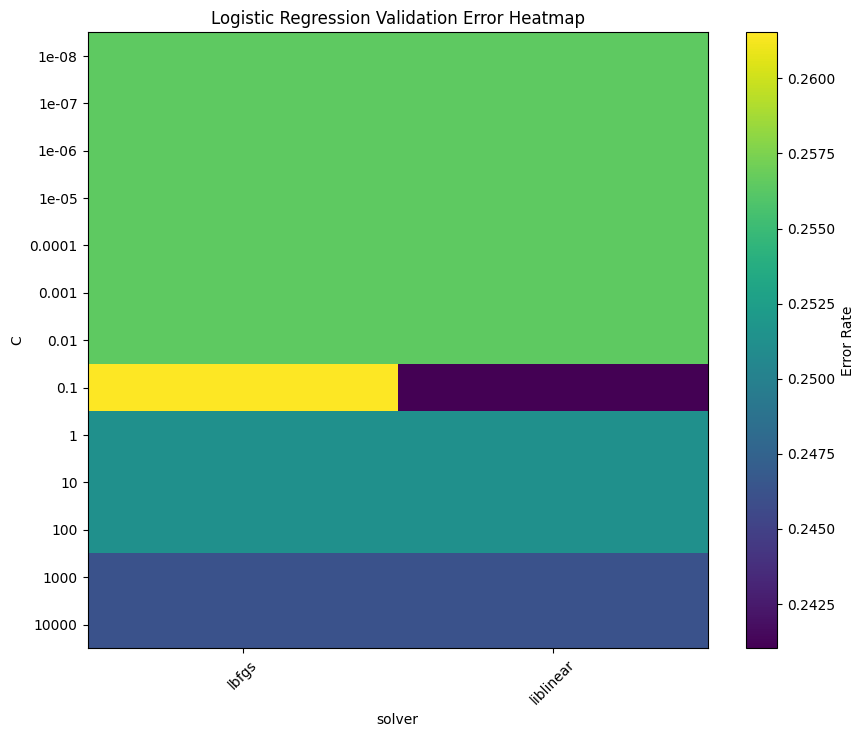

Generating heatmaps for Logistic Regression on Haberman Split 2


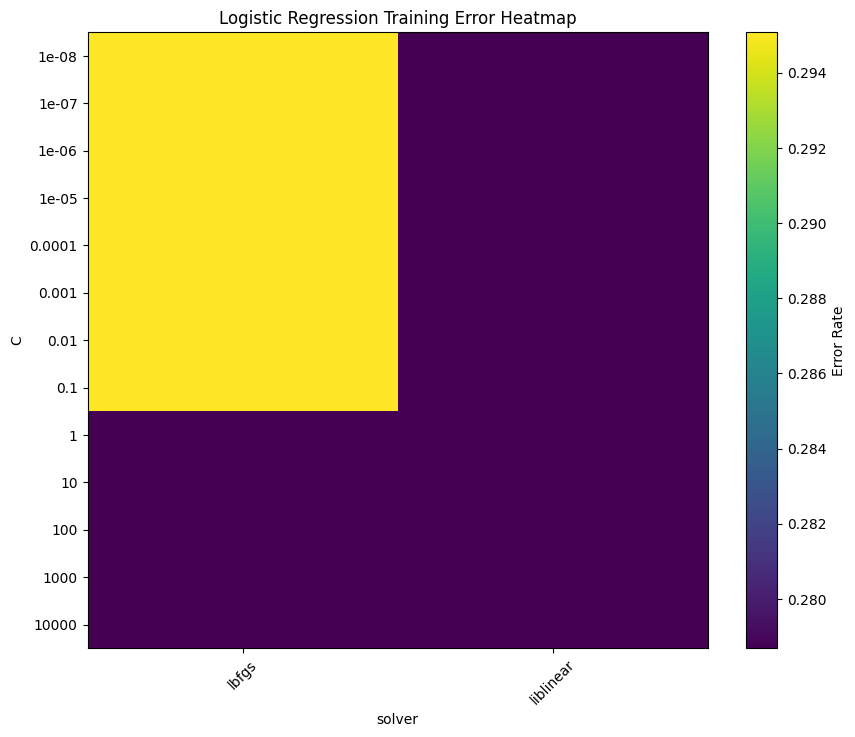

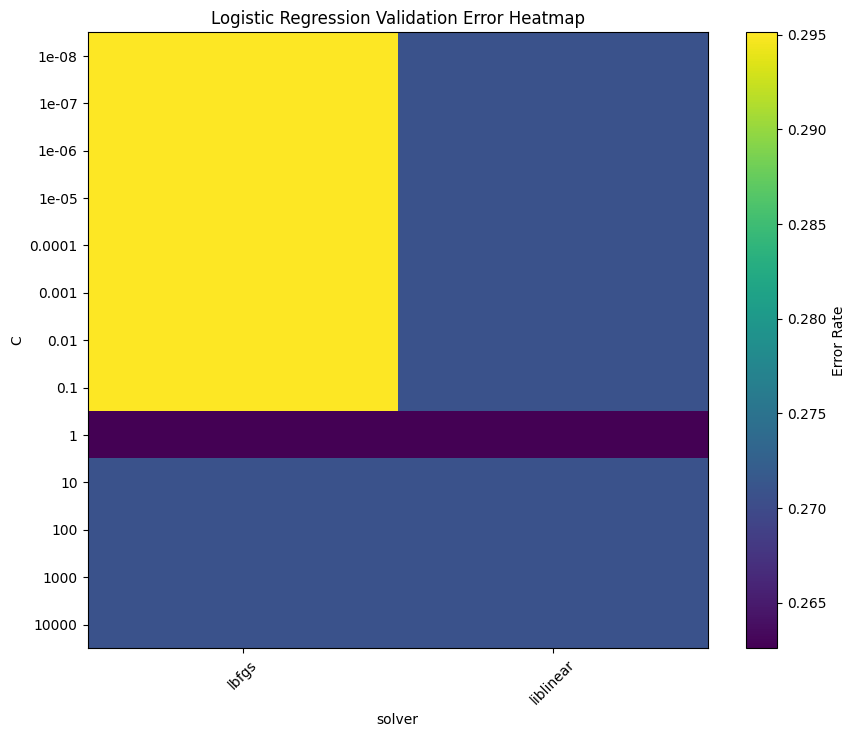

Generating heatmaps for Logistic Regression on Haberman Split 3


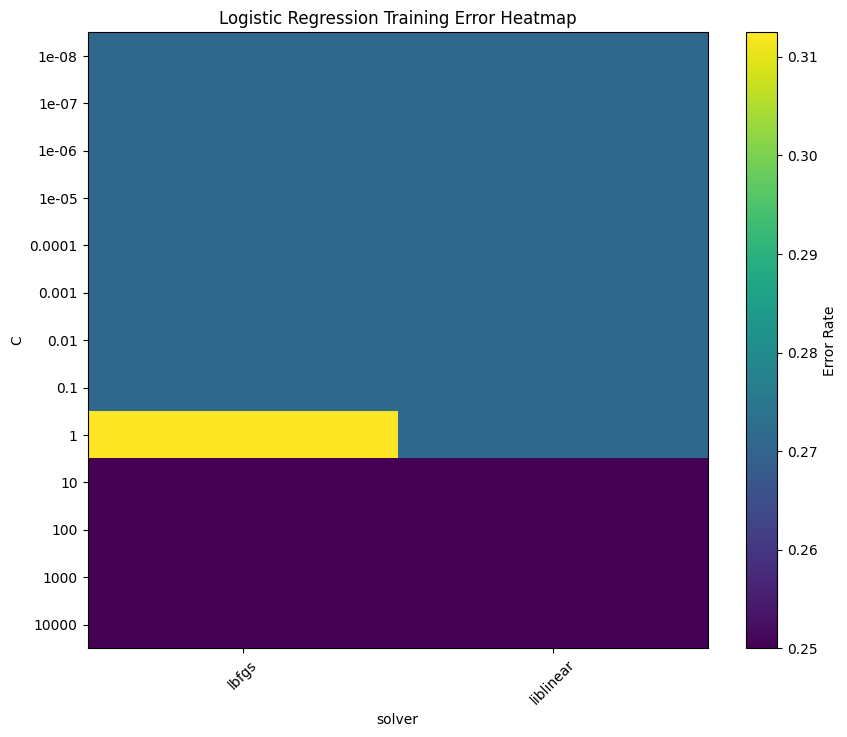

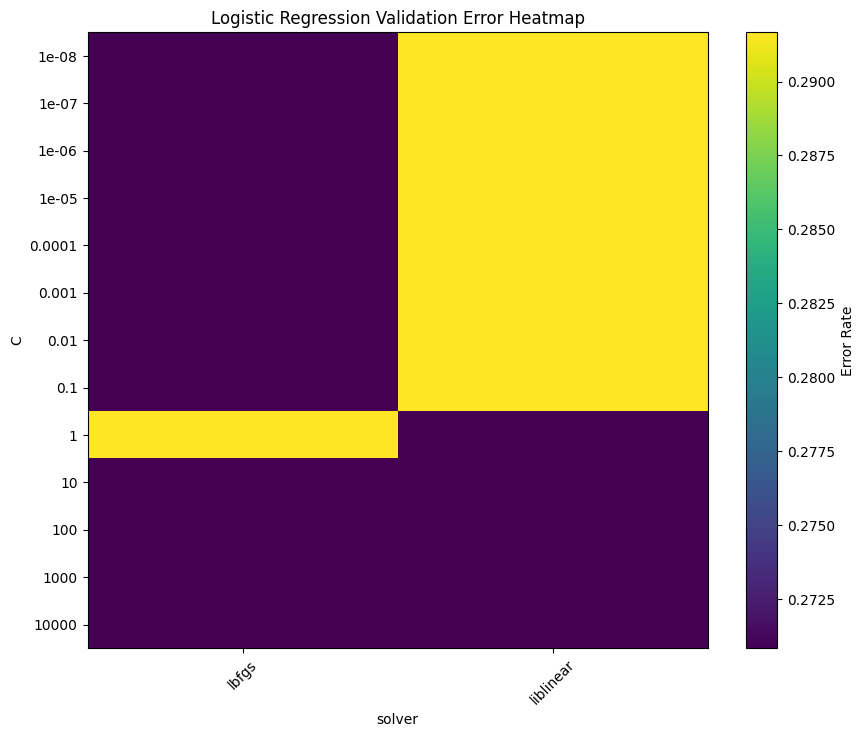

Generating heatmaps for Random Forest on Haberman Split 1


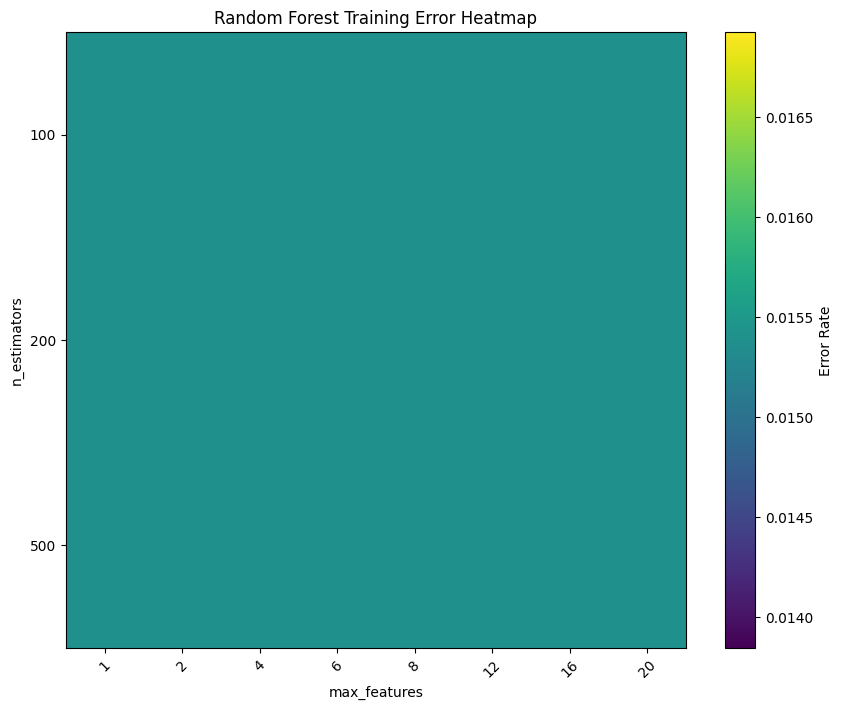

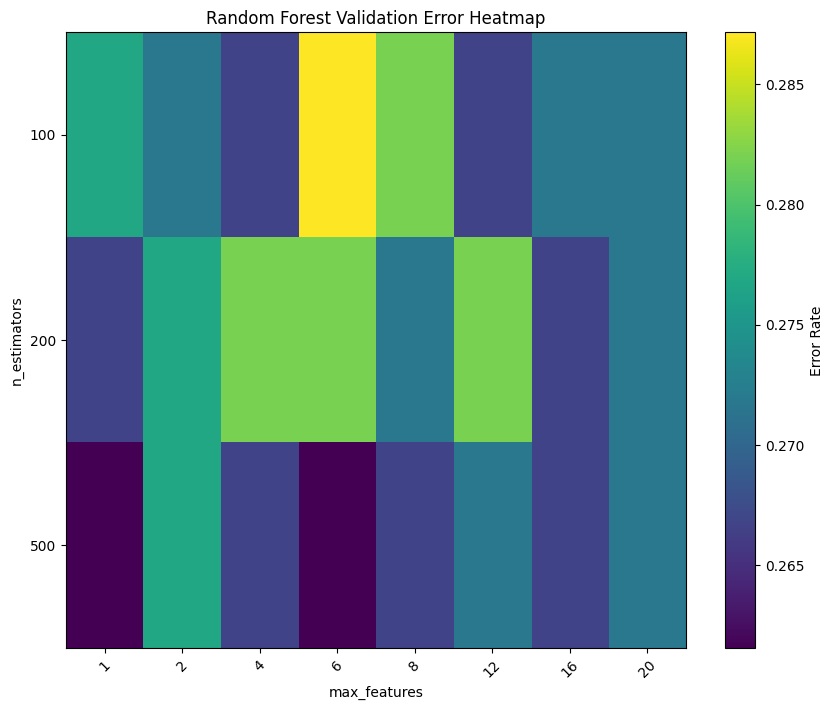

Generating heatmaps for Random Forest on Haberman Split 2


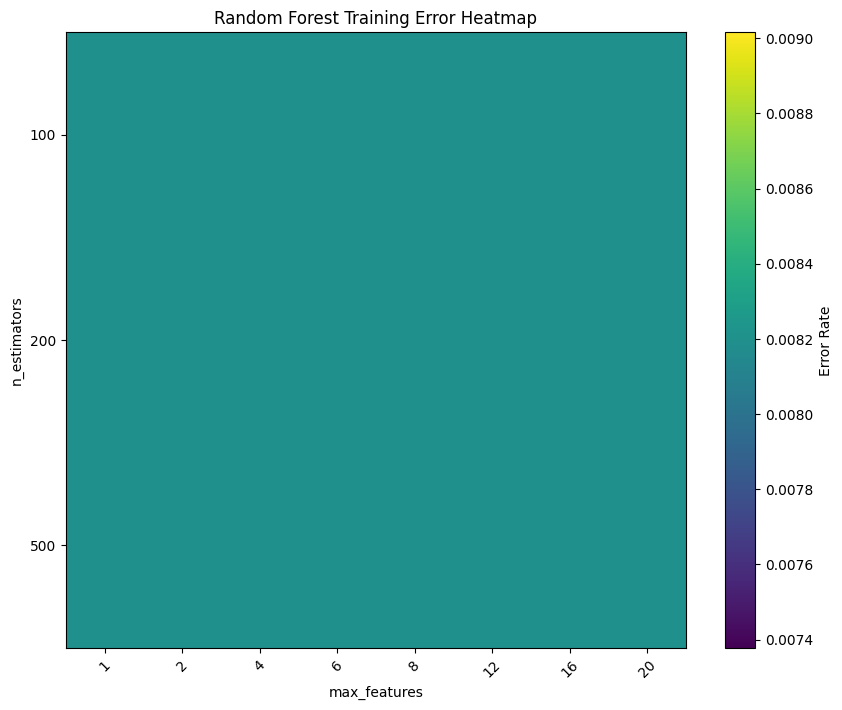

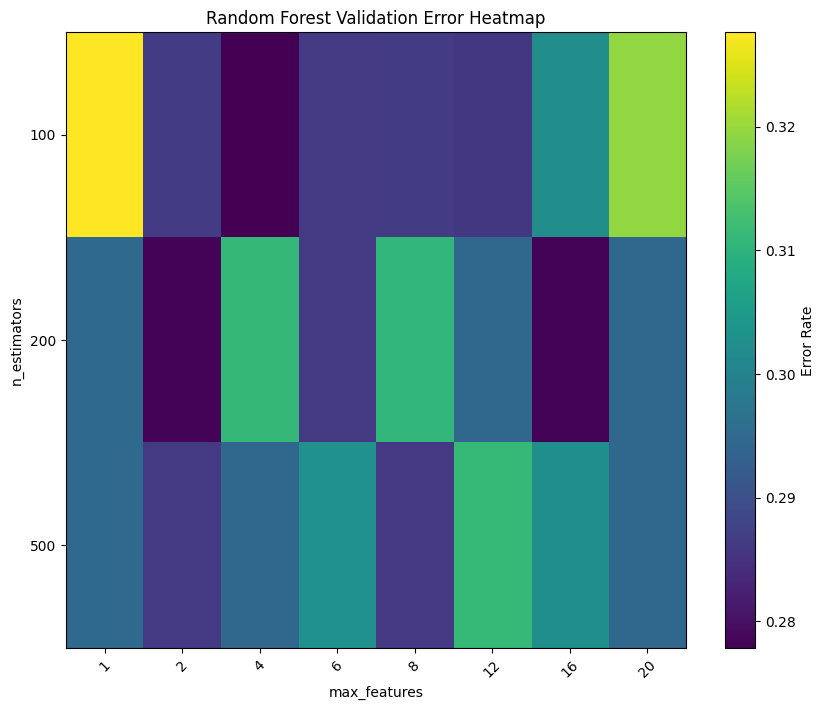

Generating heatmaps for Random Forest on Haberman Split 3


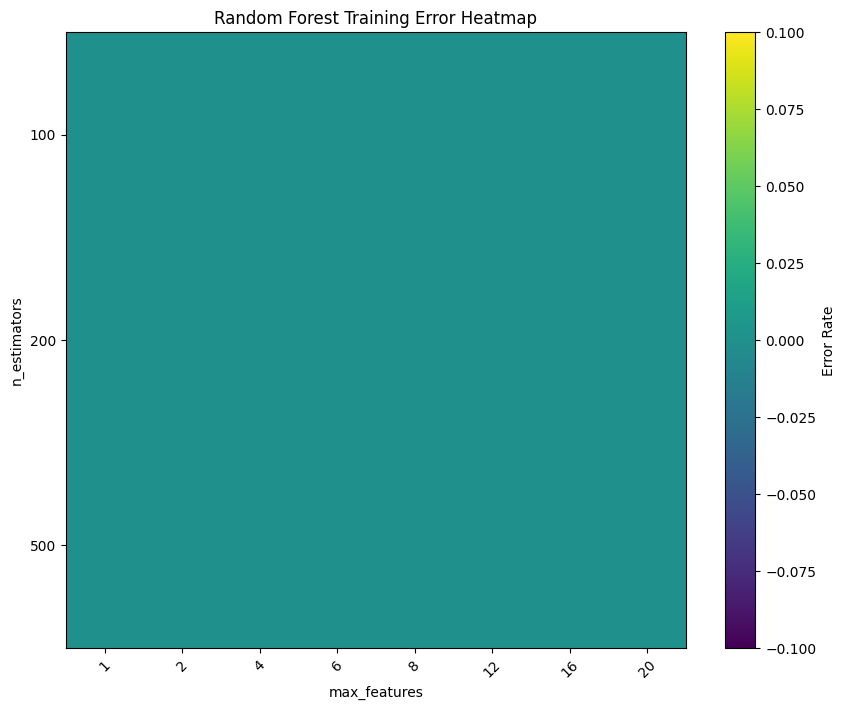

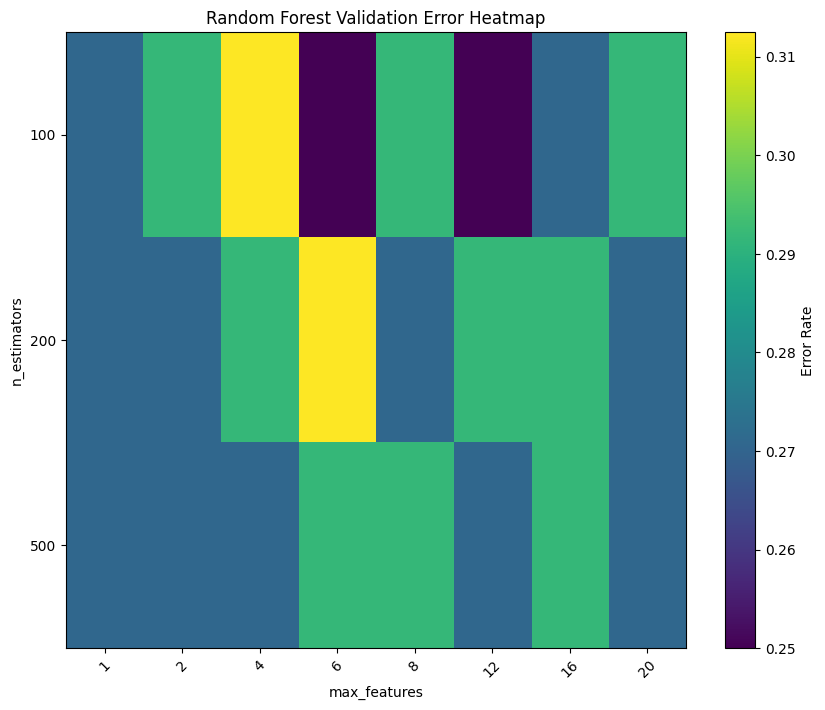

Generating heatmaps for Neural Network (ANN) on Haberman Split 1


C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\a

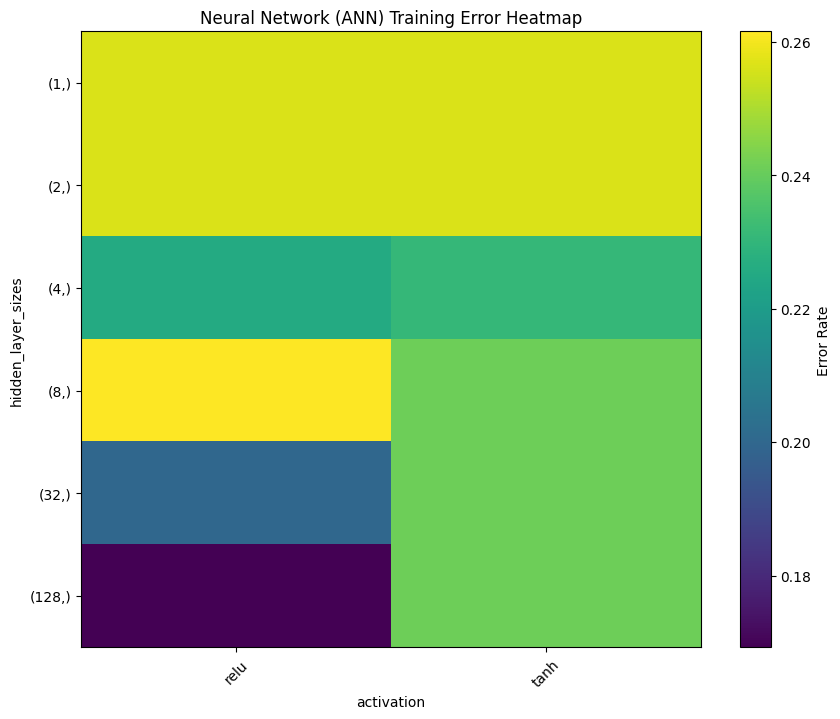

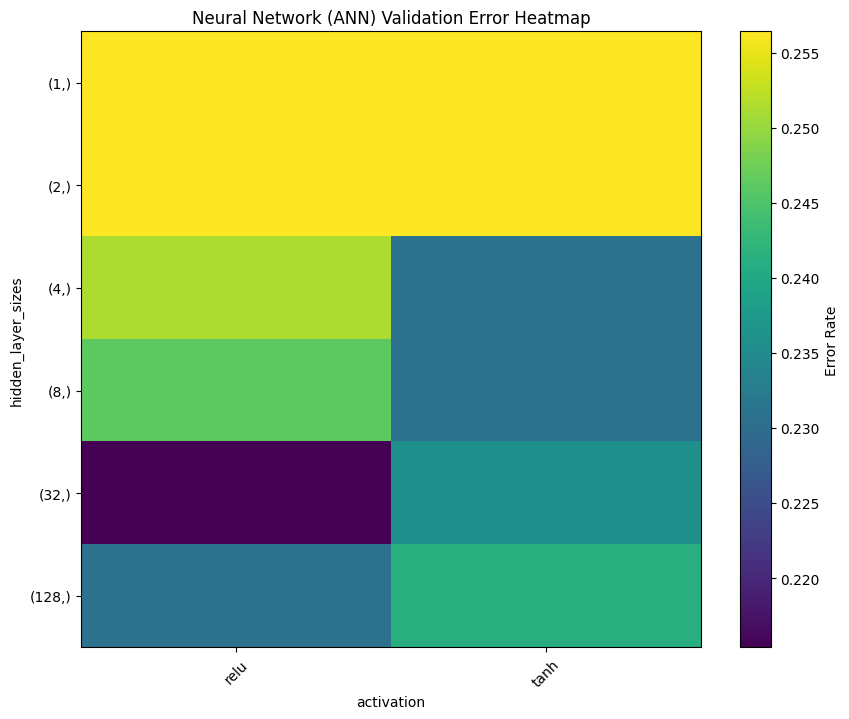

Generating heatmaps for Neural Network (ANN) on Haberman Split 2


C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\a

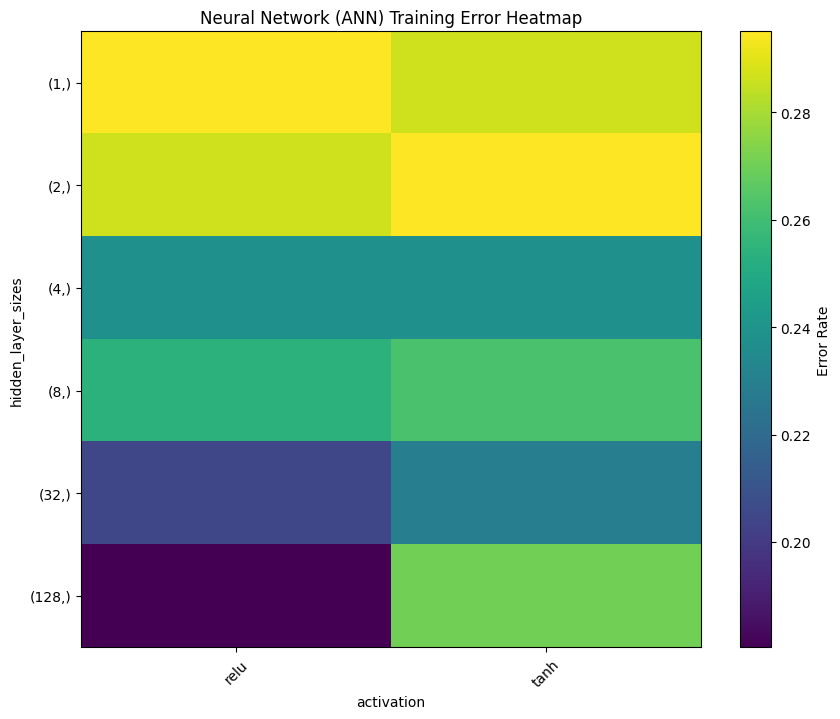

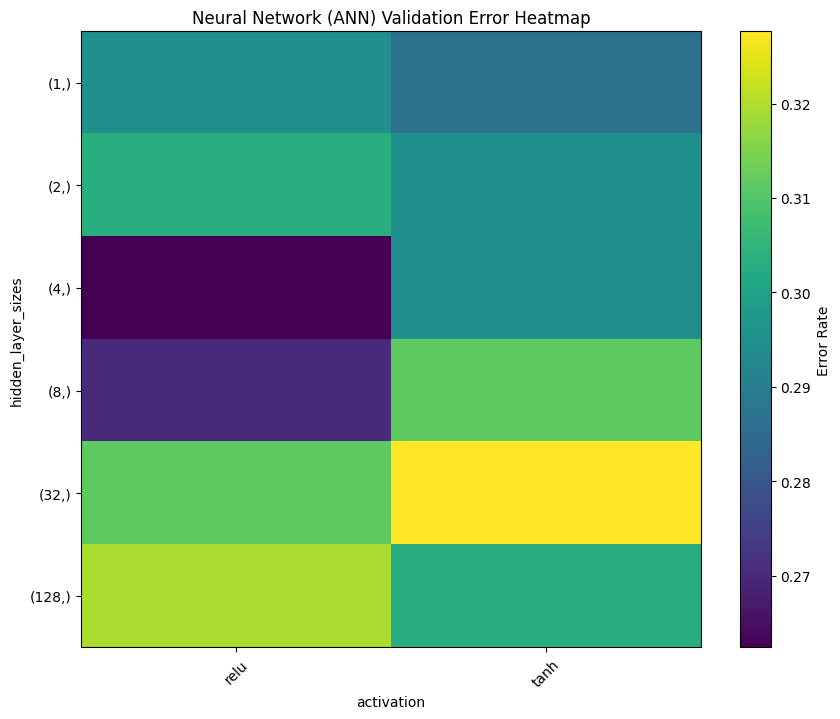

Generating heatmaps for Neural Network (ANN) on Haberman Split 3


C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shiva\a

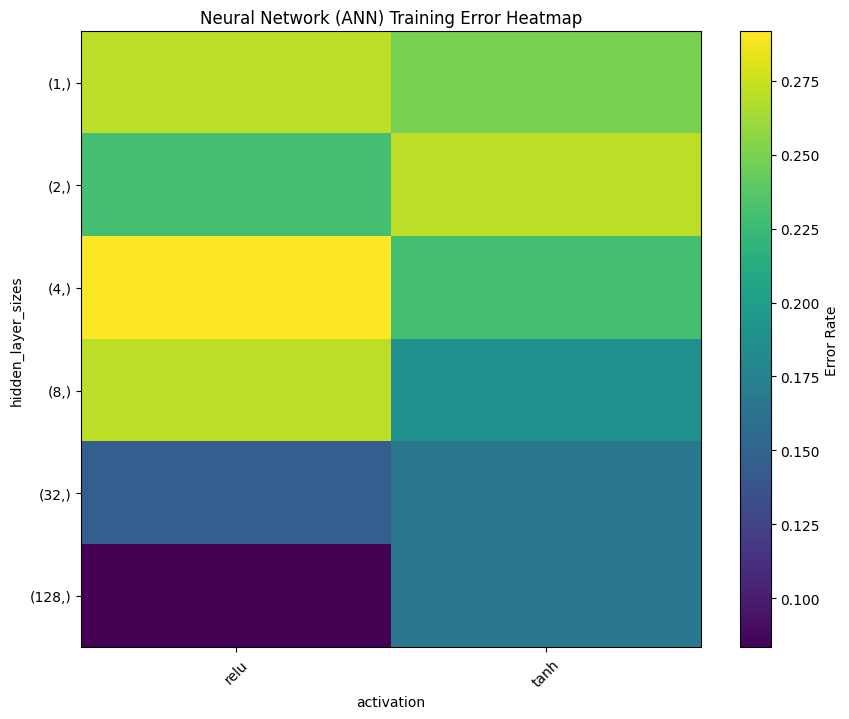

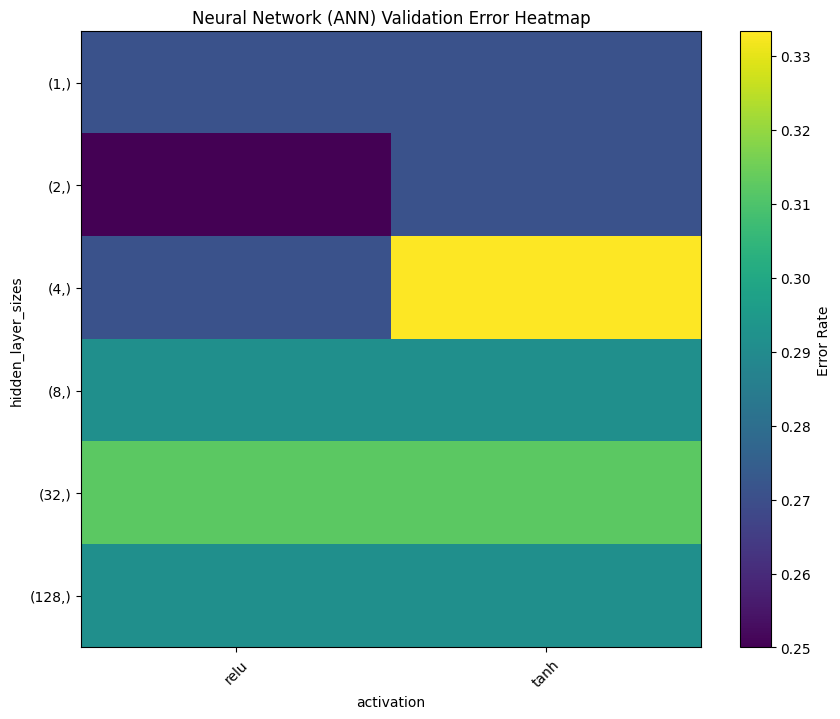

In [447]:
# Define parameters for heatmap generation
heatmap_params = {
    "SVM": ("C", "gamma"),
    "Logistic Regression": ("C", "solver"),
    "Random Forest": ("n_estimators", "max_features"),
    "Neural Network (ANN)": ("hidden_layer_sizes", "activation"),
}

# Generate heatmaps for all models
X_train_list = [splits_haberman['80/20']['X_train'], splits_haberman['50/50']['X_train'], splits_haberman['20/80']['X_train']]
y_train_list = [splits_haberman['80/20']['y_train'], splits_haberman['50/50']['y_train'], splits_haberman['20/80']['y_train']]

for model_name, (model, param_dist) in models.items():
    i = 1
    for X_train, y_train in zip(X_train_list, y_train_list):
        if model_name in heatmap_params:
            print(f"Generating heatmaps for {model_name} on Haberman Split {i}")
            param_x, param_y = heatmap_params[model_name]
            generate_heatmaps_for_model(model_name, model, param_dist, param_x, param_y, X_train, y_train)
        i += 1

### Training Models

#### Define Function

In [496]:
# Function to repeat the training process for 3 trials
def perform_trials(model_name, model, data_splits, n_trials=3, cv=5):
    avg_results = {}

    for split_name, split_data in data_splits.items():
        print(f"Processing {split_name} split for {model_name}...")
        results = {'train_accuracy': [], 'cv_accuracy': [], 'test_accuracy': []}
        
        for trial in range(n_trials):
            print(f"Running trial {trial + 1} for {model_name} on {split_name} split...")
            
            # Extract train, validation, and test splits
            X_train, X_test = split_data['X_train'], split_data['X_test']
            y_train, y_test = split_data['y_train'], split_data['y_test']

            # Perform cross-validation on the training data
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
            cv_accuracy = np.mean(cv_scores)

            # Train the model on the entire training data
            model.fit(X_train, y_train)

            # Evaluate on train and test sets
            train_acc = accuracy_score(y_train, model.predict(X_train))
            test_acc = accuracy_score(y_test, model.predict(X_test))
            
            # Train and evaluate the model
            #trial_results = train_and_evaluate(model_name, model, X_train, X_valid, X_test, y_train, y_valid, y_test)
            
            # Store the results for this trial
            results['train_accuracy'].append(train_acc)
            results['cv_accuracy'].append(cv_accuracy)
            results['test_accuracy'].append(test_acc)

        # Average the results over the trials for this partition
        avg_results[split_name] = {
            'avg_train_accuracy': np.mean(results['train_accuracy']),
            'avg_cv_accuracy': np.mean(results['cv_accuracy']),
            'avg_test_accuracy': np.mean(results['test_accuracy']),
        }
        
    return avg_results

#### Train Classifiers on Datasets

In [632]:
train_results = []

for model_name, best_params in param_grids.items():
    print(f"Training and evaluating {model_name} with the best parameters: {best_params}")
    
    # Get the model from the 'get_models()' function
    model = get_models()[model_name][0]
    
    # Set the best hyperparameters in the model
    model.set_params(**best_params)
    
    # Perform trials on Haberman dataset
    avg_results_haberman = perform_trials(model_name, model, splits_haberman)
    for split_name in avg_results_haberman:
        train_results.append({
            'Model': model_name,
            'Dataset': 'Haberman',
            'Split': split_name,
            'Best Parameters': best_params,
            'Train Accuracy': avg_results_haberman[split_name]['avg_train_accuracy'],
            'CV Accuracy': avg_results_haberman[split_name]['avg_cv_accuracy'],
            'Test Accuracy': avg_results_haberman[split_name]['avg_test_accuracy'],
        })
    
    # Perform trials on WDBC dataset
    avg_results_wdbc = perform_trials(model_name, model, splits_wdbc)
    for split_name in avg_results_wdbc:
        train_results.append({
            'Model': model_name,
            'Dataset': 'WDBC',
            'Split': split_name,
            'Best Parameters': best_params,
            'Train Accuracy': avg_results_wdbc[split_name]['avg_train_accuracy'],
            'CV Accuracy': avg_results_wdbc[split_name]['avg_cv_accuracy'],
            'Test Accuracy': avg_results_wdbc[split_name]['avg_test_accuracy'],
        })
    
    # Perform trials on Diabetes dataset
    avg_results_diabetes = perform_trials(model_name, model, splits_diabetes)
    for split_name in avg_results_diabetes:
        train_results.append({
            'Model': model_name,
            'Dataset': 'Diabetes',
            'Split': split_name,
            'Best Parameters': best_params,
            'Train Accuracy': avg_results_diabetes[split_name]['avg_train_accuracy'],
            'CV Accuracy': avg_results_diabetes[split_name]['avg_cv_accuracy'],
            'Test Accuracy': avg_results_diabetes[split_name]['avg_test_accuracy'],
        })

# Convert the list of results into a DataFrame
train_results_df = pd.DataFrame(train_results)

train_results_df

Training and evaluating Logistic Regression with the best parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
Processing 80/20 split for Logistic Regression...
Running trial 1 for Logistic Regression on 80/20 split...
Running trial 2 for Logistic Regression on 80/20 split...
Running trial 3 for Logistic Regression on 80/20 split...
Processing 50/50 split for Logistic Regression...
Running trial 1 for Logistic Regression on 50/50 split...
Running trial 2 for Logistic Regression on 50/50 split...
Running trial 3 for Logistic Regression on 50/50 split...
Processing 20/80 split for Logistic Regression...
Running trial 1 for Logistic Regression on 20/80 split...
Running trial 2 for Logistic Regression on 20/80 split...
Running trial 3 for Logistic Regression on 20/80 split...
Processing 80/20 split for Logistic Regression...
Running trial 1 for Logistic Regression on 80/20 split...
Running trial 2 for Logistic Regression on 80/20 split...
Running trial 3 for Logistic Regression on 80/2

,Model,Dataset,Split,Best Parameters,Train Accuracy,CV Accuracy,Test Accuracy
0,Logistic Regression,Haberman,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.766393,0.757993,0.693548
1,Logistic Regression,Haberman,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.718954,0.712043,0.777778
2,Logistic Regression,Haberman,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.737705,0.705128,0.734694
3,Logistic Regression,WDBC,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.986813,0.973626,0.973684
4,Logistic Regression,WDBC,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.985915,0.978885,0.982456
5,Logistic Regression,WDBC,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.973451,0.973518,0.973684
6,Logistic Regression,Diabetes,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.935096,0.913454,0.923077
7,Logistic Regression,Diabetes,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.938462,0.888462,0.907692
8,Logistic Regression,Diabetes,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.971154,0.933333,0.887019
9,Neural Network (ANN),Haberman,80/20,"{'solver': 'sgd', 'n_iter_no_change': 10, 'mom...",0.770492,0.770153,0.661290


## 4. Evaluation
- Use cross-validation results to evaluate models using the performance metrics (accuracy, ROC, PRC).
- Compare metrics across datasets and classifiers.
- Plot performance curves (ROC curve, precision-recall curve).

In [681]:
# Function to calculate and plot ROC curve
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(fontsize=10, bbox_to_anchor = (0,-0.5), loc='lower left', ncol=3)

# Function to calculate and plot Precision-Recall curve
def plot_precision_recall_curve(precision, recall, label):
    plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(fontsize=10, bbox_to_anchor = (0,-0.5), loc='lower left', ncol=3)

Evaluating Logistic Regression


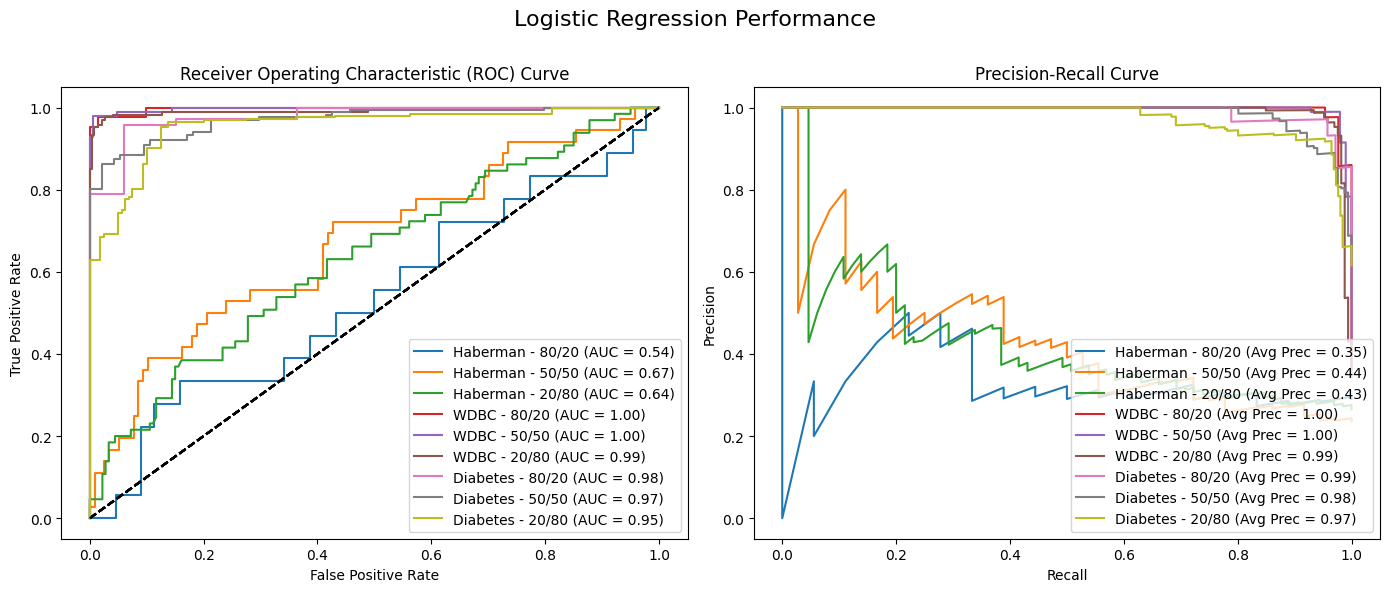

Evaluating Neural Network (ANN)


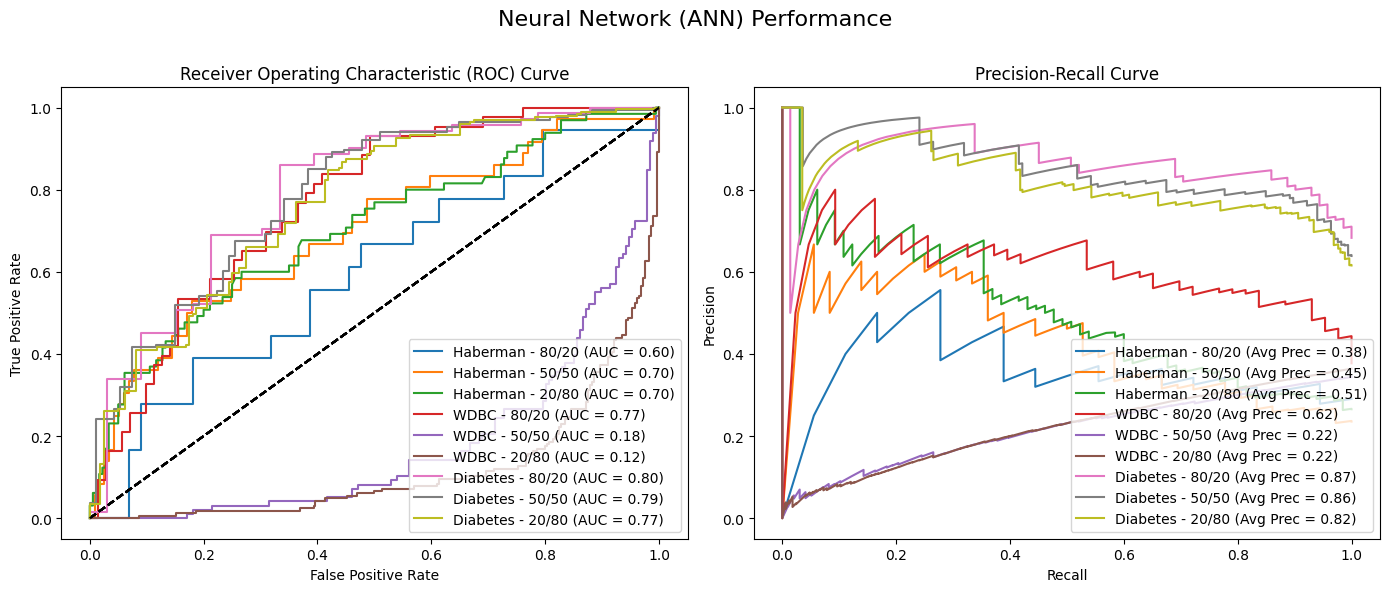

Evaluating Random Forest


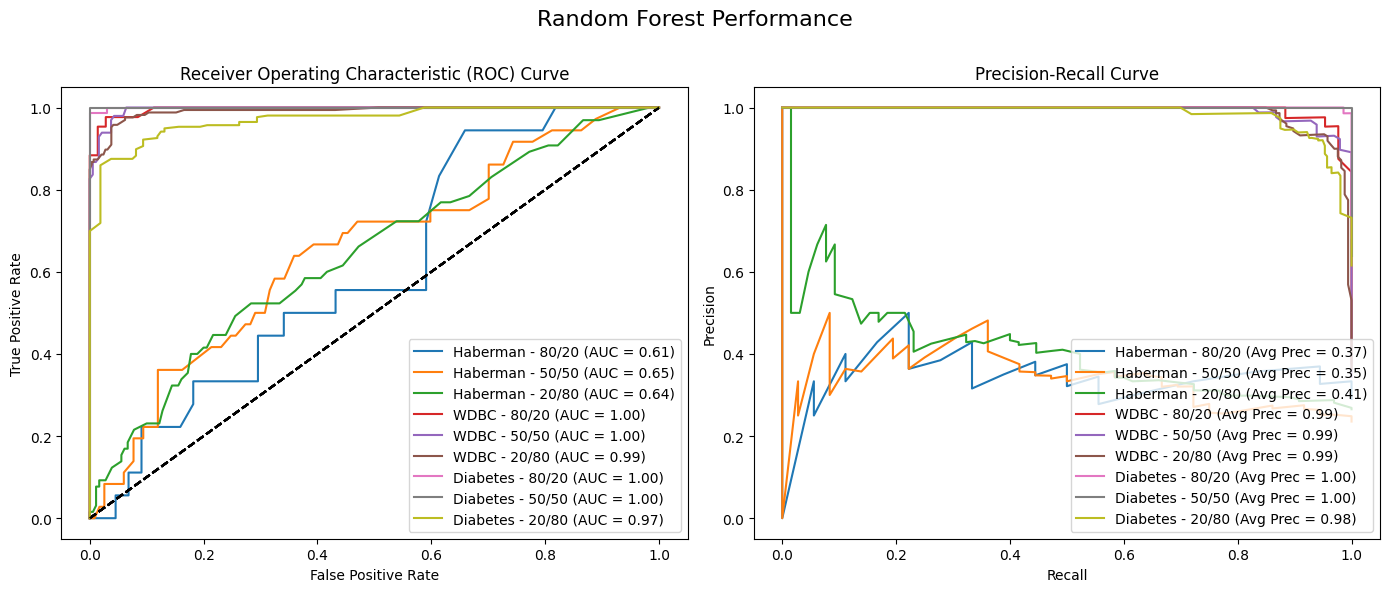

Evaluating SVM


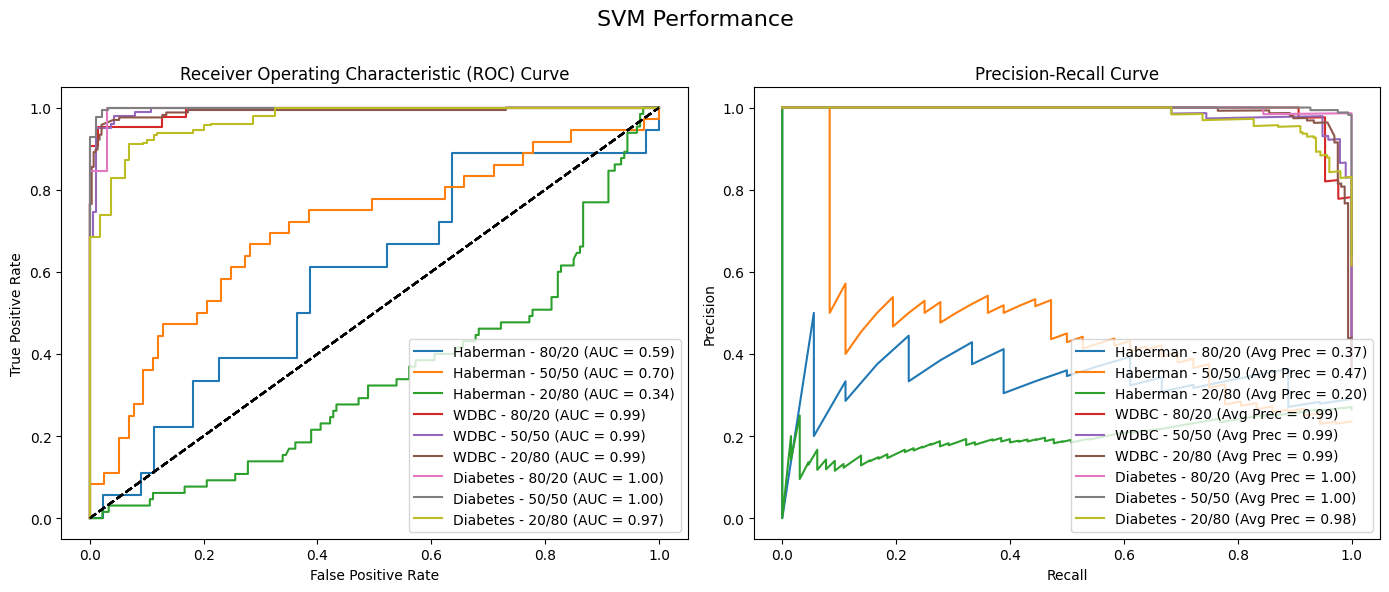

In [713]:
# Define datasets
datasets = {
    "Haberman": splits_haberman,
    "WDBC": splits_wdbc,
    "Diabetes": splits_diabetes,
}

# Empty array to store the results for ROC and PRC
auc_apr_results = []

# Evaluate and plot for each model
for model_name, best_params in param_grids.items():
    print(f"Evaluating {model_name}")
    
    model = get_models()[model_name][0]
        
    # Set the best hyperparameters in the model
    model.set_params(**best_params)
    
    # Create a new figure for each model (2 subplots: ROC and Precision-Recall)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Iterate through each dataset and data partition
    for dataset_name, splits in datasets.items():
        for split_name, split_data in splits.items():
            X_train, X_test = split_data['X_train'], split_data['X_test']
            y_train, y_test = split_data['y_train'], split_data['y_test']

            # Train the model
            model.fit(X_train, y_train)
            
            # Get the predicted probabilities (for ROC curve)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            # Calculate Precision-Recall curve and average precision score
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            avg_precision = average_precision_score(y_test, y_prob)

            # Store AUC and APR for later addition to train_results_df
            auc_apr_results.append({
                'Model': model_name,
                'Dataset': dataset_name,
                'Split': split_name,
                'ROC AUC': roc_auc,
                'APR (Avg Precision)': avg_precision
            })

            # Plot ROC curve on the first subplot (axes[0])
            axes[0].plot(fpr, tpr, label=f"{dataset_name} - {split_name} (AUC = {roc_auc:.2f})")
            axes[0].plot([0, 1], [0, 1], 'k--')
            axes[0].set_xlabel('False Positive Rate')
            axes[0].set_ylabel('True Positive Rate')
            axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
            axes[0].legend(fontsize=10, loc='lower right')

            # Plot Precision-Recall curve on the second subplot (axes[1])
            axes[1].plot(recall, precision, label=f"{dataset_name} - {split_name} (Avg Prec = {avg_precision:.2f})")
            axes[1].set_xlabel('Recall')
            axes[1].set_ylabel('Precision')
            axes[1].set_title('Precision-Recall Curve')
            axes[1].legend(fontsize=10, loc='lower right')

    # Adjust layout and show the plot for this model
    plt.tight_layout()
    plt.suptitle(f"{model_name} Performance", fontsize=16)
    plt.subplots_adjust(top=0.85)  # To make room for the subtitle
    plt.show()

In [719]:
auc_apr_df = pd.DataFrame(auc_apr_results)

# Merge with the existing train_results_df
train_results_df = pd.merge(train_results_df, auc_apr_df, 
                             on=['Model', 'Dataset', 'Split'], 
                             how='left')

train_results_df

,Model,Dataset,Split,Best Parameters,Train Accuracy,CV Accuracy,Test Accuracy,ROC AUC,APR (Avg Precision)
0,Logistic Regression,Haberman,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.766393,0.757993,0.693548,0.535354,0.347515
1,Logistic Regression,Haberman,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.718954,0.712043,0.777778,0.669753,0.438074
2,Logistic Regression,Haberman,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.737705,0.705128,0.734694,0.635598,0.427525
3,Logistic Regression,WDBC,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.986813,0.973626,0.973684,0.997380,0.996203
4,Logistic Regression,WDBC,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.985915,0.978885,0.982456,0.997763,0.996392
5,Logistic Regression,WDBC,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.973451,0.973518,0.973684,0.990569,0.990608
6,Logistic Regression,Diabetes,80/20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.935096,0.913454,0.923077,0.977379,0.989713
7,Logistic Regression,Diabetes,50/50,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.938462,0.888462,0.907692,0.970008,0.984917
8,Logistic Regression,Diabetes,20/80,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.971154,0.933333,0.887019,0.954785,0.973335
9,Neural Network (ANN),Haberman,80/20,"{'solver': 'sgd', 'n_iter_no_change': 10, 'mom...",0.770492,0.770153,0.661290,0.595960,0.379618


In [723]:
averaged_results_df = train_results_df.groupby('Model').agg({
    'Train Accuracy': 'mean',
    'CV Accuracy': 'mean',
    'Test Accuracy': 'mean',
    'ROC AUC': 'mean',
    'APR (Avg Precision)': 'mean'
}).reset_index()

averaged_results_df

,Model,Train Accuracy,CV Accuracy,Test Accuracy,ROC AUC,APR (Avg Precision)
0,Logistic Regression,0.890438,0.870716,0.872626,0.858732,0.793809
1,Neural Network (ANN),0.591211,0.562876,0.562819,0.600658,0.548120
2,Random Forest,0.997452,0.881225,0.879434,0.872528,0.787242
3,SVM,0.921703,0.872686,0.883338,0.841695,0.776439


In [752]:
# Calculate the average score for Test Accuracy, ROC AUC, and APR
averaged_results_df['Average Score'] = averaged_results_df[['Test Accuracy', 'ROC AUC', 'APR (Avg Precision)']].mean(axis=1)

# Rank models based on the average score (higher is better)
averaged_results_df['Rank'] = averaged_results_df['Average Score'].rank(ascending=False)

# Sort by rank
df_sorted = averaged_results_df.sort_values(by='Rank').reset_index()

# Display the ranked models
df_sorted[['Model', 'Train Accuracy', 'CV Accuracy', 'Test Accuracy', 'ROC AUC', 'APR (Avg Precision)', 'Average Score']]

,Model,Train Accuracy,CV Accuracy,Test Accuracy,ROC AUC,APR (Avg Precision),Average Score
0,Random Forest,0.997452,0.881225,0.879434,0.872528,0.787242,0.846401
1,Logistic Regression,0.890438,0.870716,0.872626,0.858732,0.793809,0.841722
2,SVM,0.921703,0.872686,0.883338,0.841695,0.776439,0.833824
3,Neural Network (ANN),0.591211,0.562876,0.562819,0.600658,0.548120,0.570532


In [755]:
# Table for Report
data = {
    "Dataset": [
        "Haberman", "Haberman", "Haberman",
        "WDBC", "WDBC", "WDBC",
        "Diabetes", "Diabetes", "Diabetes"
    ],
    "Partition": [
        "80/20", "50/50", "20/80",
        "80/20", "50/50", "20/80",
        "80/20", "50/50", "20/80"
    ],
    "Train Size": [
        "244", "153", "61",
        "455", "284", "113",
        "416", "260", "104"
    ],
    "Test Size": [
        "62", "153", "245",
        "114", "285", "456",
        "104", "260", "416"
    ]
}

df = pd.DataFrame(data)
df

,Dataset,Partition,Train Size,Test Size
0,Haberman,80/20,244,62
1,Haberman,50/50,153,153
2,Haberman,20/80,61,245
3,WDBC,80/20,455,114
4,WDBC,50/50,284,285
5,WDBC,20/80,113,456
6,Diabetes,80/20,416,104
7,Diabetes,50/50,260,260
8,Diabetes,20/80,104,416
